In [1]:
import numpy as np
from scipy.integrate import odeint

In [2]:
def simulate_lorenz_96(p, T, F=10.0, delta_t=0.1, sd=0.1, burn_in=1000,
                       seed=0):
    if seed is not None:
        np.random.seed(seed)

    # Use scipy to solve ODE.
    x0 = np.random.normal(scale=0.01, size=p)
    t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
    X = odeint(lorenz, x0, t, args=(F,))
    X += np.random.normal(scale=sd, size=(T + burn_in, p))

    # Set up Granger causality ground truth.
    GC = np.zeros((p, p), dtype=int)
    for i in range(p):
        GC[i, i] = 1
        GC[i, (i + 1) % p] = 1
        GC[i, (i - 1) % p] = 1
        GC[i, (i - 2) % p] = 1

    return X[burn_in:], GC

In [8]:
import numpy as np
import matplotlib.pyplot as plt
  
import torch
import torch.nn as nn
import numpy as np
from copy import deepcopy

In [10]:
def train_model_ista(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    pred = [clstm.networks[i](X)[0] for i in range(p)]
    loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
    ridge = sum([ridge_regularize(net, lam_ridge) for net in clstm.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in clstm.parameters():
            param.data -= lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in clstm.networks:
                prox_update(net, lam, lr)

        clstm.zero_grad()

        # Calculate loss for next iteration.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
        ridge = sum([ridge_regularize(net, lam_ridge)
                     for net in clstm.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize(net, lam) for net in clstm.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list

In [12]:
def lorenz(x, t, F):
    '''Partial derivatives for Lorenz-96 ODE.'''
    p = len(x)
    dxdt = np.zeros(p)
    for i in range(p):
        dxdt[i] = (x[(i+1) % p] - x[(i-2) % p]) * x[(i-1) % p] - x[i] + F

    return dxdt

In [13]:
device = torch.device('cuda')
X_np, GC = simulate_lorenz_96(p=10, F=10, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

In [14]:
print(X_np)
print(GC)

[[ 0.09901663  2.90255933  7.90956947 ...  7.58412067 -0.87003867
   0.61771009]
 [ 2.38325721  4.35670602  7.5971257  ...  4.76156927 -4.74652638
   2.97870363]
 [ 6.12371096  5.58656138  3.61239589 ...  2.99557554 -5.32498916
   3.21535708]
 ...
 [-0.80381534  1.65664602  1.62185873 ... 10.65667465  2.78380341
  -3.29308802]
 [ 0.19956412  2.45640257  3.63145308 ... 10.67337297 -0.5973428
  -3.51307331]
 [ 0.20966461  3.01812589  5.86000539 ... 10.10419812 -3.20311821
  -0.30507416]]
[[1 1 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 0 1]
 [1 1 1 1 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 1 1 1]]


In [20]:
class LSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        LSTM model with output layer to generate predictions.
        Args:
          num_series: number of input time series.
          hidden: number of hidden units.
        '''
        super(LSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up network.
        self.lstm = nn.LSTM(num_series, hidden, batch_first=True)
        self.lstm.flatten_parameters()
        self.linear = nn.Conv1d(hidden, 1, 1)

    def init_hidden(self, batch):
        '''Initialize hidden states for LSTM cell.'''
        device = self.lstm.weight_ih_l0.device
        return (torch.zeros(1, batch, self.hidden, device=device),
                torch.zeros(1, batch, self.hidden, device=device))

    def forward(self, X, hidden=None):
        # Set up hidden state.
        if hidden is None:
            hidden = self.init_hidden(X.shape[0])

        # Apply LSTM.
        X, hidden = self.lstm(X, hidden)

        # Calculate predictions using output layer.
        X = X.transpose(2, 1)
        X = self.linear(X)
        return X.transpose(2, 1), hidden


class cLSTM(nn.Module):
    def __init__(self, num_series, hidden):
        '''
        cLSTM model with one LSTM per time series.
        Args:
          num_series: dimensionality of multivariate time series.
          hidden: number of units in LSTM cell.
        '''
        super(cLSTM, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up networks.
        self.networks = nn.ModuleList([
            LSTM(num_series, hidden) for _ in range(num_series)])

    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for LSTM cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X, hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden

    def GC(self, threshold=True):
        '''
        Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.norm(net.lstm.weight_ih_l0, dim=0)
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


class cLSTMSparse(nn.Module):
    def __init__(self, num_series, sparsity, hidden):
        '''
        cLSTM model that only uses specified interactions.
        Args:
          num_series: dimensionality of multivariate time series.
          sparsity: torch byte tensor indicating Granger causality, with size
            (num_series, num_series).
          hidden: number of units in LSTM cell.
        '''
        super(cLSTMSparse, self).__init__()
        self.p = num_series
        self.hidden = hidden
        self.sparsity = sparsity

        # Set up networks.
        self.networks = nn.ModuleList([
            LSTM(int(torch.sum(sparsity[i].int())), hidden)
            for i in range(num_series)])

    def forward(self, X, hidden=None):
        '''
        Perform forward pass.
        Args:
          X: torch tensor of shape (batch, T, p).
          hidden: hidden states for LSTM cell.
        '''
        if hidden is None:
            hidden = [None for _ in range(self.p)]
        pred = [self.networks[i](X[:, :, self.sparsity[i]], hidden[i])
                for i in range(self.p)]
        pred, hidden = zip(*pred)
        pred = torch.cat(pred, dim=2)
        return pred, hidden


def prox_update(network, lam, lr):
    '''Perform in place proximal update on first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    norm = torch.norm(W, dim=0, keepdim=True)
    W.data = ((W / torch.clamp(norm, min=(lam * lr)))
              * torch.clamp(norm - (lr * lam), min=0.0))
    network.lstm.flatten_parameters()


def regularize(network, lam):
    '''Calculate regularization term for first layer weight matrix.'''
    W = network.lstm.weight_ih_l0
    return lam * torch.sum(torch.norm(W, dim=0))


def ridge_regularize(network, lam):
    '''Apply ridge penalty at linear layer and hidden-hidden weights.'''
    return lam * (
        torch.sum(network.linear.weight ** 2) +
        torch.sum(network.lstm.weight_hh_l0 ** 2))


def restore_parameters(model, best_model):
    '''Move parameter values from best_model to model.'''
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params


def arrange_input(data, context):
    '''
    Arrange a single time series into overlapping short sequences.
    Args:
      data: time series of shape (T, dim).
      context: length of short sequences.
    '''
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()


def train_model_gista(clstm, X, context, lam, lam_ridge, lr, max_iter,
                      check_every=50, r=0.8, lr_min=1e-8, sigma=0.5,
                      monotone=False, m=10, lr_decay=0.5,
                      begin_line_search=True, switch_tol=1e-3, verbose=1):
    '''
    Train cLSTM model with GISTA.
    Args:
      clstm: clstm model.
      X: tensor of data, shape (batch, T, p).
      context: length for short overlapping subsequences.
      lam: parameter for nonsmooth regularization.
      lam_ridge: parameter for ridge regularization on output layer.
      lr: learning rate.
      max_iter: max number of GISTA iterations.
      check_every: how frequently to record loss.
      r: for line search.
      lr_min: for line search.
      sigma: for line search.
      monotone: for line search.
      m: for line search.
      lr_decay: for adjusting initial learning rate of line search.
      begin_line_search: whether to begin with line search.
      switch_tol: tolerance for switching to line search.
      verbose: level of verbosity (0, 1, 2).
    '''
    p = clstm.p
    clstm_copy = deepcopy(clstm)
    loss_fn = nn.MSELoss(reduction='mean')
    lr_list = [lr for _ in range(p)]

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # Calculate full loss.
    mse_list = []
    smooth_list = []
    loss_list = []
    for i in range(p):
        net = clstm.networks[i]
        pred, _ = net(X)
        mse = loss_fn(pred[:, :, 0], Y[:, :, i])
        ridge = ridge_regularize(net, lam_ridge)
        smooth = mse + ridge
        mse_list.append(mse)
        smooth_list.append(smooth)
        with torch.no_grad():
            nonsmooth = regularize(net, lam)
            loss = smooth + nonsmooth
            loss_list.append(loss)

    # Set up lists for loss and mse.
    with torch.no_grad():
        loss_mean = sum(loss_list) / p
        mse_mean = sum(mse_list) / p
    train_loss_list = [loss_mean]
    train_mse_list = [mse_mean]

    # For switching to line search.
    line_search = begin_line_search

    # For line search criterion.
    done = [False for _ in range(p)]
    assert 0 < sigma <= 1
    assert m > 0
    if not monotone:
        last_losses = [[loss_list[i]] for i in range(p)]

    for it in range(max_iter):
        # Backpropagate errors.
        sum([smooth_list[i] for i in range(p) if not done[i]]).backward()

        # For next iteration.
        new_mse_list = []
        new_smooth_list = []
        new_loss_list = []

        # Perform GISTA step for each network.
        for i in range(p):
            # Skip if network converged.
            if done[i]:
                new_mse_list.append(mse_list[i])
                new_smooth_list.append(smooth_list[i])
                new_loss_list.append(loss_list[i])
                continue

            # Prepare for line search.
            step = False
            lr_it = lr_list[i]
            net = clstm.networks[i]
            net_copy = clstm_copy.networks[i]

            while not step:
                # Perform tentative ISTA step.
                for param, temp_param in zip(net.parameters(),
                                             net_copy.parameters()):
                    temp_param.data = param - lr_it * param.grad

                # Proximal update.
                prox_update(net_copy, lam, lr_it)

                # Check line search criterion.
                pred, _ = net_copy(X)
                mse = loss_fn(pred[:, :, 0], Y[:, :, i])
                ridge = ridge_regularize(net_copy, lam_ridge)
                smooth = mse + ridge
                with torch.no_grad():
                    nonsmooth = regularize(net_copy, lam)
                    loss = smooth + nonsmooth
                    tol = (0.5 * sigma / lr_it) * sum(
                        [torch.sum((param - temp_param) ** 2)
                         for param, temp_param in
                         zip(net.parameters(), net_copy.parameters())])

                comp = loss_list[i] if monotone else max(last_losses[i])
                if not line_search or (comp - loss) > tol:
                    step = True
                    if verbose > 1:
                        print('Taking step, network i = %d, lr = %f'
                              % (i, lr_it))
                        print('Gap = %f, tol = %f' % (comp - loss, tol))

                    # For next iteration.
                    new_mse_list.append(mse)
                    new_smooth_list.append(smooth)
                    new_loss_list.append(loss)

                    # Adjust initial learning rate.
                    lr_list[i] = (
                        (lr_list[i] ** (1 - lr_decay)) * (lr_it ** lr_decay))

                    if not monotone:
                        if len(last_losses[i]) == m:
                            last_losses[i].pop(0)
                        last_losses[i].append(loss)
                else:
                    # Reduce learning rate.
                    lr_it *= r
                    if lr_it < lr_min:
                        done[i] = True
                        new_mse_list.append(mse_list[i])
                        new_smooth_list.append(smooth_list[i])
                        new_loss_list.append(loss_list[i])
                        if verbose > 0:
                            print('Network %d converged' % (i + 1))
                        break

            # Clean up.
            net.zero_grad()

            if step:
                # Swap network parameters.
                clstm.networks[i], clstm_copy.networks[i] = net_copy, net

        # For next iteration.
        mse_list = new_mse_list
        smooth_list = new_smooth_list
        loss_list = new_loss_list

        # Check if all networks have converged.
        if sum(done) == p:
            if verbose > 0:
                print('Done at iteration = %d' % (it + 1))
            break

        # Check progress
        if (it + 1) % check_every == 0:
            with torch.no_grad():
                loss_mean = sum(loss_list) / p
                mse_mean = sum(mse_list) / p
                ridge_mean = (sum(smooth_list) - sum(mse_list)) / p
                nonsmooth_mean = (sum(loss_list) - sum(smooth_list)) / p

            train_loss_list.append(loss_mean)
            train_mse_list.append(mse_mean)

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Total loss = %f' % loss_mean)
                print('MSE = %f, Ridge = %f, Nonsmooth = %f'
                      % (mse_mean, ridge_mean, nonsmooth_mean))
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check whether loss has increased.
            if not line_search:
                if train_loss_list[-2] - train_loss_list[-1] < switch_tol:
                    line_search = True
                    if verbose > 0:
                        print('Switching to line search')

    return train_loss_list, train_mse_list


def train_model_adam(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(clstm.parameters(), lr=lr)
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    for it in range(max_iter):
        # Calculate loss.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])

        # Add penalty term.
        if lam > 0:
            loss = loss + sum([regularize(net, lam) for net in clstm.networks])

        if lam_ridge > 0:
            loss = loss + sum([ridge_regularize(net, lam_ridge)
                               for net in clstm.networks])

        # Take gradient step.
        loss.backward()
        optimizer.step()
        clstm.zero_grad()

        # Check progress.
        if (it + 1) % check_every == 0:
            mean_loss = loss / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list


def train_model_ista(clstm, X, context, lr, max_iter, lam=0, lam_ridge=0,
                     lookback=5, check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    # Calculate smooth error.
    pred = [clstm.networks[i](X)[0] for i in range(p)]
    loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
    ridge = sum([ridge_regularize(net, lam_ridge) for net in clstm.networks])
    smooth = loss + ridge

    for it in range(max_iter):
        # Take gradient step.
        smooth.backward()
        for param in clstm.parameters():
            param.data -= lr * param.grad

        # Take prox step.
        if lam > 0:
            for net in clstm.networks:
                prox_update(net, lam, lr)

        clstm.zero_grad()

        # Calculate loss for next iteration.
        pred = [clstm.networks[i](X)[0] for i in range(p)]
        loss = sum([loss_fn(pred[i][:, :, 0], Y[:, :, i]) for i in range(p)])
        ridge = sum([ridge_regularize(net, lam_ridge)
                     for net in clstm.networks])
        smooth = loss + ridge

        # Check progress.
        if (it + 1) % check_every == 0:
            # Add nonsmooth penalty.
            nonsmooth = sum([regularize(net, lam) for net in clstm.networks])
            mean_loss = (smooth + nonsmooth) / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)
                print('Variable usage = %.2f%%'
                      % (100 * torch.mean(clstm.GC().float())))

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list


def train_unregularized(clstm, X, context, lr, max_iter, lookback=5,
                        check_every=50, verbose=1):
    '''Train model with Adam.'''
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(clstm.parameters(), lr=lr)
    train_loss_list = []

    # Set up data.
    X, Y = zip(*[arrange_input(x, context) for x in X])
    X = torch.cat(X, dim=0)
    Y = torch.cat(Y, dim=0)

    # For early stopping.
    best_it = None
    best_loss = np.inf
    best_model = None

    for it in range(max_iter):
        # Calculate loss.
        pred, hidden = clstm(X)
        loss = sum([loss_fn(pred[:, :, i], Y[:, :, i]) for i in range(p)])

        # Take gradient step.
        loss.backward()
        optimizer.step()
        clstm.zero_grad()

        # Check progress.
        if (it + 1) % check_every == 0:
            mean_loss = loss / p
            train_loss_list.append(mean_loss.detach())

            if verbose > 0:
                print(('-' * 10 + 'Iter = %d' + '-' * 10) % (it + 1))
                print('Loss = %f' % mean_loss)

            # Check for early stopping.
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_it = it
                best_model = deepcopy(clstm)
            elif (it - best_it) == lookback * check_every:
                if verbose:
                    print('Stopping early')
                break

    # Restore best model.
    restore_parameters(clstm, best_model)

    return train_loss_list

In [21]:
clstm = cLSTM(X.shape[-1], hidden=100).cuda(device=device)
train_loss_list = train_model_ista(
    clstm, X, context=10, lam=10.0, lam_ridge=1e-2, lr=1e-3, max_iter=20000,
    check_every=50)

----------Iter = 50----------
Loss = 86.845192
Variable usage = 100.00%
----------Iter = 100----------
Loss = 38.276245
Variable usage = 100.00%
----------Iter = 150----------
Loss = 21.874128
Variable usage = 22.00%
----------Iter = 200----------
Loss = 20.476919
Variable usage = 17.00%
----------Iter = 250----------
Loss = 19.647699
Variable usage = 15.00%
----------Iter = 300----------
Loss = 19.091482
Variable usage = 15.00%
----------Iter = 350----------
Loss = 18.683994
Variable usage = 15.00%
----------Iter = 400----------
Loss = 18.359785
Variable usage = 17.00%
----------Iter = 450----------
Loss = 18.079021
Variable usage = 20.00%
----------Iter = 500----------
Loss = 17.819624
Variable usage = 25.00%
----------Iter = 550----------
Loss = 17.571495
Variable usage = 27.00%
----------Iter = 600----------
Loss = 17.330166
Variable usage = 28.00%
----------Iter = 650----------
Loss = 17.094746
Variable usage = 28.00%
----------Iter = 700----------
Loss = 16.865398
Variable usage 

----------Iter = 5700----------
Loss = 9.015396
Variable usage = 36.00%
----------Iter = 5750----------
Loss = 8.987741
Variable usage = 36.00%
----------Iter = 5800----------
Loss = 8.960411
Variable usage = 36.00%
----------Iter = 5850----------
Loss = 8.933415
Variable usage = 37.00%
----------Iter = 5900----------
Loss = 8.906749
Variable usage = 37.00%
----------Iter = 5950----------
Loss = 8.880415
Variable usage = 37.00%
----------Iter = 6000----------
Loss = 8.854391
Variable usage = 37.00%
----------Iter = 6050----------
Loss = 8.828679
Variable usage = 37.00%
----------Iter = 6100----------
Loss = 8.803278
Variable usage = 37.00%
----------Iter = 6150----------
Loss = 8.778180
Variable usage = 37.00%
----------Iter = 6200----------
Loss = 8.753374
Variable usage = 37.00%
----------Iter = 6250----------
Loss = 8.728863
Variable usage = 37.00%
----------Iter = 6300----------
Loss = 8.704654
Variable usage = 37.00%
----------Iter = 6350----------
Loss = 8.680720
Variable usage =

----------Iter = 11400----------
Loss = 7.306719
Variable usage = 41.00%
----------Iter = 11450----------
Loss = 7.943285
Variable usage = 47.00%
----------Iter = 11500----------
Loss = 7.293257
Variable usage = 41.00%
----------Iter = 11550----------
Loss = 7.289017
Variable usage = 41.00%
----------Iter = 11600----------
Loss = 7.292337
Variable usage = 43.00%
----------Iter = 11650----------
Loss = 7.277341
Variable usage = 43.00%
----------Iter = 11700----------
Loss = 7.266911
Variable usage = 40.00%
----------Iter = 11750----------
Loss = 7.264633
Variable usage = 41.00%
----------Iter = 11800----------
Loss = 7.253737
Variable usage = 42.00%
----------Iter = 11850----------
Loss = 7.244449
Variable usage = 42.00%
----------Iter = 11900----------
Loss = 7.267607
Variable usage = 43.00%
----------Iter = 11950----------
Loss = 8.327649
Variable usage = 52.00%
----------Iter = 12000----------
Loss = 7.227138
Variable usage = 42.00%
----------Iter = 12050----------
Loss = 7.253246
Va

----------Iter = 17050----------
Loss = 10.980513
Variable usage = 45.00%
----------Iter = 17100----------
Loss = 6.814874
Variable usage = 40.00%
----------Iter = 17150----------
Loss = 6.793804
Variable usage = 40.00%
----------Iter = 17200----------
Loss = 6.978200
Variable usage = 46.00%
----------Iter = 17250----------
Loss = 6.787875
Variable usage = 41.00%
----------Iter = 17300----------
Loss = 6.784895
Variable usage = 41.00%
----------Iter = 17350----------
Loss = 8.638019
Variable usage = 54.00%
----------Iter = 17400----------
Loss = 6.795036
Variable usage = 39.00%
----------Iter = 17450----------
Loss = 6.782236
Variable usage = 41.00%
----------Iter = 17500----------
Loss = 6.789529
Variable usage = 40.00%
----------Iter = 17550----------
Loss = 14.321657
Variable usage = 59.00%
----------Iter = 17600----------
Loss = 6.781985
Variable usage = 41.00%
----------Iter = 17650----------
Loss = 7.292339
Variable usage = 46.00%
----------Iter = 17700----------
Loss = 6.773602


True variable usage = 40.00%
Estimated variable usage = 41.00%
Accuracy = 97.00%


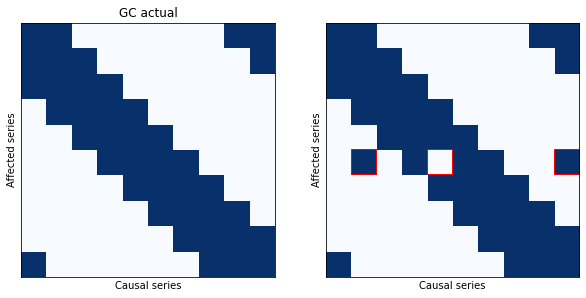

In [22]:
GC_est = clstm.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()